# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario1-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 1985090 X 25781 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in [5,10,15,20]: #range(kmin, kmax + 1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../../../../data-pre-processing/2csv/cenario1_8M2020_tweets_en.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 1985090 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("english.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 179 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 26105 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario1_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [37]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2549
K=10: Coherence=0.2349
K=15: Coherence=0.2347
K=20: Coherence=0.2236


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [38]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

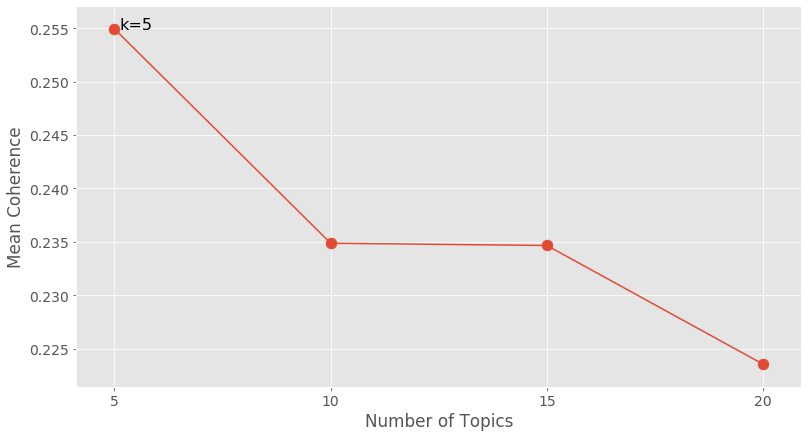

In [39]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [40]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2028
K=10: Coherence=0.1832
K=15: Coherence=0.1860
K=20: Coherence=0.1945


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


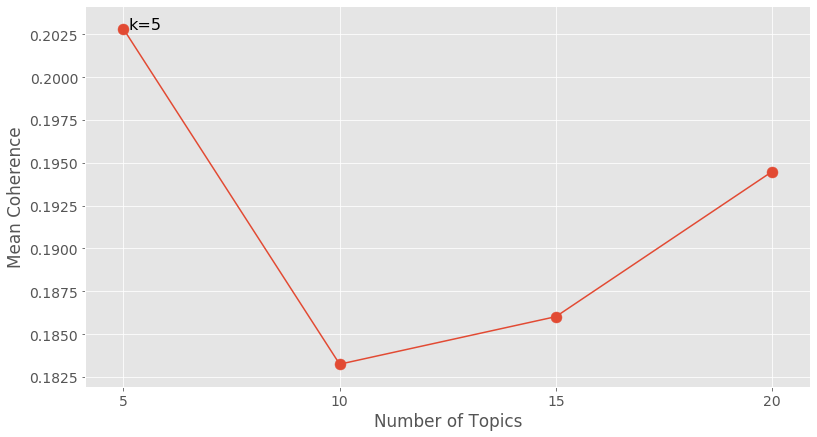

In [41]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15

In [46]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.1802
K=10: Coherence=0.1722
K=15: Coherence=0.1708
K=20: Coherence=0.1774


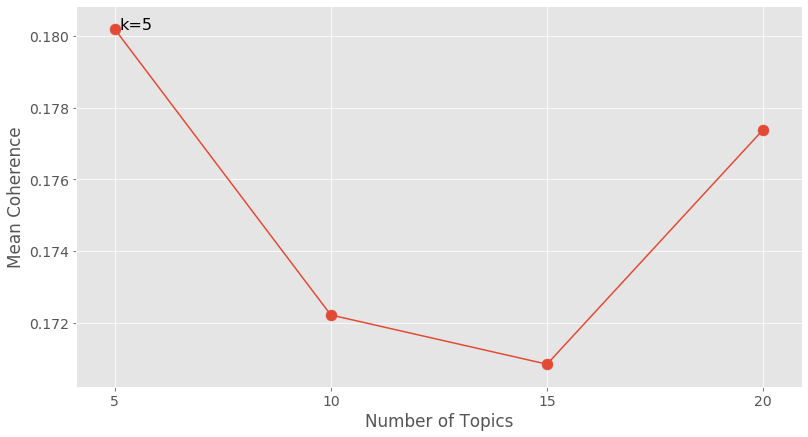

In [47]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [48]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2028
K=10: Coherence=0.1832
K=15: Coherence=0.1860
K=20: Coherence=0.1945


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


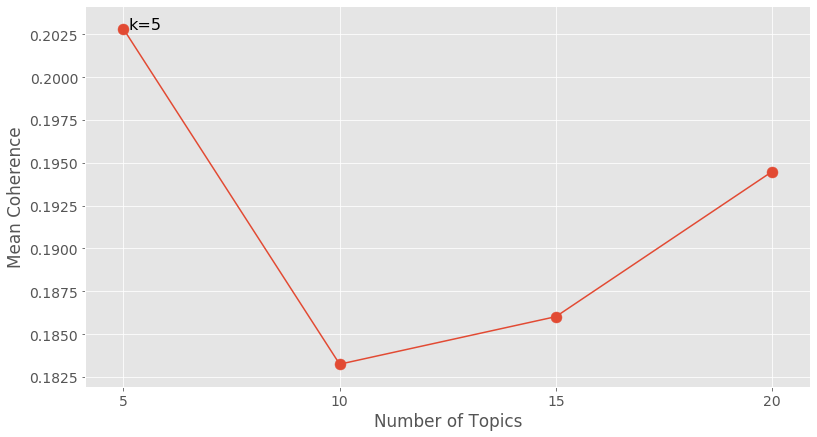

In [49]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

# 5

In [17]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [18]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, everyday, ladies, women
Topic 02: women, world, day, amp, celebrate
Topic 03: international, day, womens, fine, dedicating
Topic 04: today, justice, every, equality, gender
Topic 05: respect, elect, black, woman, believe


In [19]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, everyday, ladies, women, everyone, spirit, friends, sisters, womanhood
Topic 02: women, world, day, amp, celebrate, amazing, strong, celebrating, make, life
Topic 03: international, day, womens, fine, dedicating, woman, women, every, slaves, fighters
Topic 04: today, justice, every, equality, gender, equal, equity, celebrations, societies, congratulations
Topic 05: respect, elect, black, woman, believe, one, position, vote, please, every


In [20]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, everyday, ladies, women, everyone, spirit, friends, sisters, womanhood, ears, iwd, dear, define, ready
Topic 02: women, world, day, amp, celebrate, amazing, strong, celebrating, make, life, let, love, power, girls, incredible
Topic 03: international, day, womens, fine, dedicating, woman, women, every, slaves, fighters, ladies, womxn, gigi, bryant, lahat
Topic 04: today, justice, every, equality, gender, equal, equity, celebrations, societies, congratulations, recognise, remember, far, climate, want
Topic 05: respect, elect, black, woman, believe, one, position, vote, please, every, love, fine, dedicating, give, man


In [21]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, everyday, ladies, women, everyone, spirit, friends, sisters, womanhood, ears, iwd, dear, define, ready, less, stay, incredible, beautiful, queen
Topic 02: women, world, day, amp, celebrate, amazing, strong, celebrating, make, life, let, love, power, girls, incredible, proud, around, thank, work, rights
Topic 03: international, day, womens, fine, dedicating, woman, women, every, slaves, fighters, ladies, womxn, gigi, bryant, lahat, precious, inventing, heroine, lorde, pure
Topic 04: today, justice, every, equality, gender, equal, equity, celebrations, societies, congratulations, recognise, remember, far, climate, want, without, still, men, day, women
Topic 05: respect, elect, black, woman, believe, one, position, vote, please, every, love, fine, dedicating, give, man, never, believed, support, superpower, right


# 10

In [22]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [23]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, everyday, day, ladies, sisters
Topic 02: women, amazing, celebrating, day, celebrate
Topic 03: day, international, womens, women, every
Topic 04: today, justice, every, equality, celebrations
Topic 05: respect, elect, black, believe, position
Topic 06: woman, womens, fine, dedicating, international
Topic 07: world, equal, enabled, around, let
Topic 08: amp, love, thank, life, ladies
Topic 09: need, single, work, pay, wondered
Topic 10: best, compost, ever, turn, thing


In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, everyday, day, ladies, sisters, everyone, spirit, friends, iwd, womanhood
Topic 02: women, amazing, celebrating, day, celebrate, power, make, incredible, strong, define
Topic 03: day, international, womens, women, every, slaves, ladies, fighters, womxn, everyone
Topic 04: today, justice, every, equality, celebrations, equity, congratulations, societies, recognise, remember
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, give
Topic 06: woman, womens, fine, dedicating, international, believed, superpower, man, successful, every
Topic 07: world, equal, enabled, around, let, equality, gender, across, better, make
Topic 08: amp, love, thank, life, ladies, girls, strong, every, woman, follow
Topic 09: need, single, work, pay, wondered, earn, poor, feminism, case, producing
Topic 10: best, compost, ever, turn, thing, women, wishes, woman, one, right


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, everyday, day, ladies, sisters, everyone, spirit, friends, iwd, womanhood, beautiful, ears, dear, less, stay
Topic 02: women, amazing, celebrating, day, celebrate, power, make, incredible, strong, define, difference, proud, wonderful, inspire, powerful
Topic 03: day, international, womens, women, every, slaves, ladies, fighters, womxn, everyone, one, precious, gigi, bryant, march
Topic 04: today, justice, every, equality, celebrations, equity, congratulations, societies, recognise, remember, far, climate, gender, want, without
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, give, never, every, encourage, lift, support
Topic 06: woman, womens, fine, dedicating, international, believed, superpower, man, successful, every, behind, benz, strong, bertha, magic
Topic 07: world, equal, enabled, around, let, equality, gender, across, better, make, sisters, fight, celebrating, celebrate, girls
Topic 08: amp, love, thank, life, ladies, girls, strong

In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, everyday, day, ladies, sisters, everyone, spirit, friends, iwd, womanhood, beautiful, ears, dear, less, stay, ready, extraordinary, wishing, incredible, queen
Topic 02: women, amazing, celebrating, day, celebrate, power, make, incredible, strong, define, difference, proud, wonderful, inspire, powerful, team, trans, achievements, rights, especially
Topic 03: day, international, womens, women, every, slaves, ladies, fighters, womxn, everyone, one, precious, gigi, bryant, march, lahat, really, generation, stay, today
Topic 04: today, justice, every, equality, celebrations, equity, congratulations, societies, recognise, remember, far, climate, gender, want, without, still, men, equal, day, women
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, give, never, every, encourage, lift, support, set, let, trust, solely, based
Topic 06: woman, womens, fine, dedicating, international, believed, superpower, man, successful, every, behind, benz, strong, b

# 15

In [27]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [28]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, sisters, everyone
Topic 02: women, day, amazing, celebrate, power
Topic 03: day, international, womens, women, every
Topic 04: today, justice, every, celebrations, equity
Topic 05: respect, elect, black, believe, position
Topic 06: woman, womens, fine, dedicating, international
Topic 07: world, equal, let, enabled, around
Topic 08: amp, follow, win, chance, pop
Topic 09: proud, powerful, together, chilean, beautifully
Topic 10: best, compost, ever, turn, thing
Topic 11: celebrating, amazing, womanhood, spirit, female
Topic 12: love, strong, ladies, may, thank
Topic 13: need, single, work, pay, wondered
Topic 14: galaxy, adventures, princess, rescuing, sometimes
Topic 15: everyday, celebrate, today, let, incredible


In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, sisters, everyone, friends, spirit, womanhood, iwd, ears
Topic 02: women, day, amazing, celebrate, power, make, incredible, define, difference, wonderful
Topic 03: day, international, womens, women, every, slaves, fighters, ladies, march, womxn
Topic 04: today, justice, every, celebrations, equity, congratulations, societies, equality, recognise, remember
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, every
Topic 06: woman, womens, fine, dedicating, international, believed, every, superpower, man, successful
Topic 07: world, equal, let, enabled, around, equality, gender, across, make, better
Topic 08: amp, follow, win, chance, pop, girls, life, march, like, special
Topic 09: proud, powerful, together, chilean, beautifully, bold, incredibly, come, showing, women
Topic 10: best, compost, ever, turn, thing, women, wishes, woman, one, right
Topic 11: celebrating, amazing, womanhood, spirit, female, inspire, back, achievements, ti

In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, sisters, everyone, friends, spirit, womanhood, iwd, ears, dear, less, ready, get, beautiful
Topic 02: women, day, amazing, celebrate, power, make, incredible, define, difference, wonderful, life, team, trans, inspire, rights
Topic 03: day, international, womens, women, every, slaves, fighters, ladies, march, womxn, precious, everyone, gigi, really, one
Topic 04: today, justice, every, celebrations, equity, congratulations, societies, equality, recognise, remember, far, climate, gender, want, without
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, every, give, never, support, encourage, lift
Topic 06: woman, womens, fine, dedicating, international, believed, every, superpower, man, successful, behind, benz, bertha, car, magic
Topic 07: world, equal, let, enabled, around, equality, gender, across, make, better, celebrate, fight, girls, sisters, extraordinary
Topic 08: amp, follow, win, chance, pop, girls, life, march, like, spec

In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, sisters, everyone, friends, spirit, womanhood, iwd, ears, dear, less, ready, get, beautiful, extraordinary, wishing, stay, powerful, queen
Topic 02: women, day, amazing, celebrate, power, make, incredible, define, difference, wonderful, life, team, trans, inspire, rights, strong, many, especially, lives, making
Topic 03: day, international, womens, women, every, slaves, fighters, ladies, march, womxn, precious, everyone, gigi, really, one, bryant, today, lahat, via, stay
Topic 04: today, justice, every, celebrations, equity, congratulations, societies, equality, recognise, remember, far, climate, gender, want, without, still, men, equal, day, women
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, every, give, never, support, encourage, lift, let, set, trust, stand, get
Topic 06: woman, womens, fine, dedicating, international, believed, every, superpower, man, successful, behind, benz, bertha, car, magic, forever, lives, tribute

# 20

In [32]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [33]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, womens, sisters
Topic 02: women, amazing, day, power, celebrate
Topic 03: day, international, women, womens, every
Topic 04: today, justice, every, celebrations, equity
Topic 05: respect, elect, black, believe, position
Topic 06: womens, fine, dedicating, international, woman
Topic 07: world, equal, enabled, around, equality
Topic 08: amp, girls, life, let, thank
Topic 09: win, follow, chance, pop, amp
Topic 10: best, compost, ever, turn, thing
Topic 11: celebrating, womanhood, amazing, spirit, female
Topic 12: love, thank, much, ladies, thanks
Topic 13: need, work, pay, wondered, poor
Topic 14: galaxy, adventures, princess, rescuing, sometimes
Topic 15: woman, every, believed, successful, behind
Topic 16: back, bringing, philippine, looking, covers
Topic 17: one, men, america, right, lovely
Topic 18: strong, may, ladies, know, beautiful
Topic 19: everyday, celebrate, today, let, incredible
Topic 20: proud, powerful, together, chilean, beautifully


In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, womens, sisters, everyone, friends, spirit, womanhood, iwd
Topic 02: women, amazing, day, power, celebrate, make, incredible, define, difference, wonderful
Topic 03: day, international, women, womens, every, slaves, fighters, ladies, march, womxn
Topic 04: today, justice, every, celebrations, equity, congratulations, societies, equality, recognise, remember
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, give
Topic 06: womens, fine, dedicating, international, woman, day, shittier, gay, disabled, muslim
Topic 07: world, equal, enabled, around, equality, let, gender, across, better, make
Topic 08: amp, girls, life, let, thank, celebrate, support, special, female, get
Topic 09: win, follow, chance, pop, amp, retweet, post, winner, selected, 10th
Topic 10: best, compost, ever, turn, thing, women, wishes, thaman, hijab, link
Topic 11: celebrating, womanhood, amazing, spirit, female, inspire, achievements, today, time, received
Topi

In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, womens, sisters, everyone, friends, spirit, womanhood, iwd, dear, ears, less, ready, wishing
Topic 02: women, amazing, day, power, celebrate, make, incredible, define, difference, wonderful, inspire, trans, team, life, especially
Topic 03: day, international, women, womens, every, slaves, fighters, ladies, march, womxn, today, everyone, gigi, precious, bryant
Topic 04: today, justice, every, celebrations, equity, congratulations, societies, equality, recognise, remember, far, climate, gender, want, without
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, give, encourage, lift, never, support, let
Topic 06: womens, fine, dedicating, international, woman, day, shittier, gay, disabled, muslim, trans, color, especially, even, inventing
Topic 07: world, equal, enabled, around, equality, let, gender, across, better, make, sisters, fight, extraordinary, things, celebrate
Topic 08: amp, girls, life, let, thank, celebrate, support, spec

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: happy, day, ladies, womens, sisters, everyone, friends, spirit, womanhood, iwd, dear, ears, less, ready, wishing, get, extraordinary, beautiful, queen, powerful
Topic 02: women, amazing, day, power, celebrate, make, incredible, define, difference, wonderful, inspire, trans, team, life, especially, rights, many, black, achievements, lives
Topic 03: day, international, women, womens, every, slaves, fighters, ladies, march, womxn, today, everyone, gigi, precious, bryant, lahat, generation, stay, really, via
Topic 04: today, justice, every, celebrations, equity, congratulations, societies, equality, recognise, remember, far, climate, gender, want, without, still, men, equal, day, women
Topic 05: respect, elect, black, believe, position, vote, please, one, woman, give, encourage, lift, never, support, let, set, trust, tom, eyes, hesitant
Topic 06: womens, fine, dedicating, international, woman, day, shittier, gay, disabled, muslim, trans, color, especially, even, inventing, heroin